# Flight Delay Predictor

**Authors:**

Yusuf Medhat

Guillermo Bermejo Babiano 

## Data Loading

To improve the predicting power of the models, we will also take into account two of the available documentation datasets: `airports.csv`, `plane-data.csv` wich will be useful in the following steps.

The dataset `carriers.csv` will not be used as it does not provide any useful information for the purpose of this notebook.

### Session and Imports

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DoubleType, DateType
from pyspark.sql.functions import *
from pyspark.sql.functions import col, floor, avg, count, when, greatest, lit

from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer, Bucketizer, StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import time

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)



# Create a SparkSession
spark = SparkSession.builder \
    .appName("FlightDelayPredictor") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/02 12:50:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Flight Dataset Loading

For this analysis, we selected the three most recent datasets (2006, 2007, and 2008) to ensure relevance and data quality. Older datasets may include outdated aircraft models and technologies that do not reflect current operational realities. Additionally, datasets prior to 2001 may show different patterns due to significant changes in aviation regulations and operational practices following the September 11 attacks.

In [2]:
# Specify the list of files to load
files = [
    "../../training_data/flight_data/2006.csv.bz2",
    "../../training_data/flight_data/2007.csv.bz2",
    "../../training_data/flight_data/2008.csv.bz2"
]

# Explicit Schema Definition
# This maps to the 29 columns in your dataset
flight_schema = StructType([
    StructField("Year", IntegerType(), True),
    StructField("Month", IntegerType(), True),
    StructField("DayofMonth", IntegerType(), True),
    StructField("DayOfWeek", IntegerType(), True),
    StructField("DepTime", DoubleType(), True),
    StructField("CRSDepTime", DoubleType(), True),
    StructField("ArrTime", DoubleType(), True),           # Forbidden
    StructField("CRSArrTime", DoubleType(), True),
    StructField("UniqueCarrier", StringType(), True),
    StructField("FlightNum", IntegerType(), True),
    StructField("TailNum", StringType(), True),
    StructField("ActualElapsedTime", DoubleType(), True), # Forbidden
    StructField("CRSElapsedTime", DoubleType(), True),
    StructField("AirTime", DoubleType(), True),           # Forbidden
    StructField("ArrDelay", DoubleType(), True),          # TARGET
    StructField("DepDelay", DoubleType(), True),
    StructField("Origin", StringType(), True),
    StructField("Dest", StringType(), True),
    StructField("Distance", DoubleType(), True),
    StructField("TaxiIn", DoubleType(), True),            # Forbidden
    StructField("TaxiOut", DoubleType(), True),
    StructField("Cancelled", DoubleType(), True),
    StructField("CancellationCode", StringType(), True),
    StructField("Diverted", DoubleType(), True),          # Forbidden
    StructField("CarrierDelay", DoubleType(), True),      # Forbidden
    StructField("WeatherDelay", DoubleType(), True),      # Forbidden
    StructField("NASDelay", DoubleType(), True),          # Forbidden
    StructField("SecurityDelay", DoubleType(), True),     # Forbidden
    StructField("LateAircraftDelay", DoubleType(), True)  # Forbidden
])

# Load them all at once
df_flights = spark.read.csv(files, header=True, schema=flight_schema)

print(f"Total flights loaded: {df_flights.count()}")

Total flights loaded: 16984354


### Airport Dataset Loading

In [3]:
# Specify the list of file
airportFilePath = "../../training_data/documentation/airports.csv"

# Explicit Schema Definition
airport_schema = StructType([
    StructField("iata", StringType(), True),
    StructField("airport", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("country", StringType(), True),
    StructField("lat", DoubleType(), True),
    StructField("long", DoubleType(), True),
])

df_airports = spark.read.csv(airportFilePath, header=True, schema=airport_schema)

print(f"Total airports loaded: {df_airports.count()}")

Total airports loaded: 3376


### Plane Dataset Loading

In [4]:
# Specify the list of file
planeFilePath = "../../training_data/documentation/plane-data.csv"

# Explicit Schema Definition
plane_schema = StructType([
    StructField("tailnum", StringType(), True),
    StructField("type", StringType(), True),
    StructField("manufacturer", StringType(), True),
    StructField("issue_date", DateType(), True),
    StructField("model", StringType(), True),
    StructField("status", StringType(), True),
    StructField("aircraft_type", StringType(), True),
    StructField("engine_type", StringType(), True),
    StructField("year", IntegerType(), True),
])

df_planes = spark.read.csv(planeFilePath, header=True, schema=plane_schema)

print(f"Total planes loaded: {df_planes.count()}")

Total planes loaded: 5029


## Preprocessing & Cleaning

In [5]:
# ==============================================================================
# 1. DROP FORBIDDEN VARIABLES
# ==============================================================================
# These contain information known only AFTER the flight lands.
forbidden_vars = [
    "ArrTime", "ActualElapsedTime", "AirTime", "TaxiIn", "Diverted",
    "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay",
    "CancellationCode"
]
# Only drop columns that actually exist in the dataframe
cols_to_drop = [c for c in forbidden_vars if c in df_flights.columns]
df_clean = df_flights.drop(*cols_to_drop)

# ==============================================================================
# 2. FILTER INVALID ROWS
# ==============================================================================
# Filter Cancelled Flights: If Cancelled == 1, the plane never arrived.
# We also drop the 'Cancelled' column afterwards as it's now constant (all 0)
df_clean = df_clean.filter(col("Cancelled") == 0).drop("Cancelled")

# Drop Missing Targets: We cannot train on data where ArrDelay is missing
df_clean = df_clean.dropna(subset=["ArrDelay", "DepDelay", "Distance"])

print(f"Data Cleaning Complete. Remaining records: {df_clean.count()}")

Data Cleaning Complete. Remaining records: 16598211


## Exploratory Data Analysis (EDA)

In this section, we analyze the cleaned flight data to understand the underlying distributions and relationships. Our goal is to identify key drivers of delay to justify our feature engineering strategy. We focus on three specific hypotheses:

- Temporal Patterns: Are delays concentrated in specific "rush hours" or days?

- Operational Congestion: Do major hubs experience higher average delays than smaller airports?

- Equipment Reliability: Does the age of the aircraft correlate with delay frequency?

In [6]:
# Due to the size of the dataset, we cache it in memory for faster access
df_clean.cache()
print(f"Dataset cached. Total rows: {df_clean.count()}")

Dataset cached. Total rows: 16598211


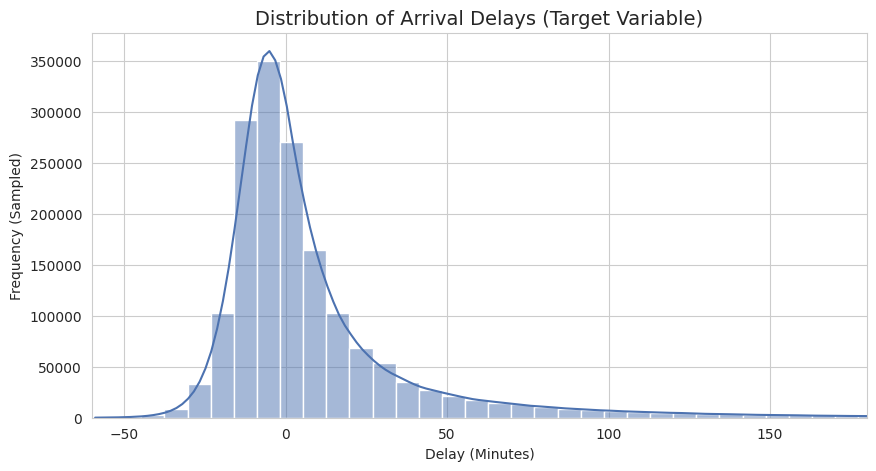

In [7]:
# ==============================================================================
# 1. Analysis of the distribution of the Target Variable (ArrDelay)
# ==============================================================================
# We sample the data for the histogram because plotting millions of points is slow/impossible
# We filter extreme outliers (>300 mins) just for the visualization clearly
target_sample = df_clean.select("ArrDelay") \
                        .filter((col("ArrDelay") > -60) & (col("ArrDelay") < 300)) \
                        .sample(withReplacement=False, fraction=0.1, seed=42) \
                        .toPandas()

plt.figure(figsize=(10, 5))
sns.histplot(target_sample['ArrDelay'], bins=50, kde=True, color="#4C72B0")
plt.title("Distribution of Arrival Delays (Target Variable)", fontsize=14)
plt.xlabel("Delay (Minutes)")
plt.ylabel("Frequency (Sampled)")
plt.xlim(-60, 180) # Focus on the main body of data
plt.show()

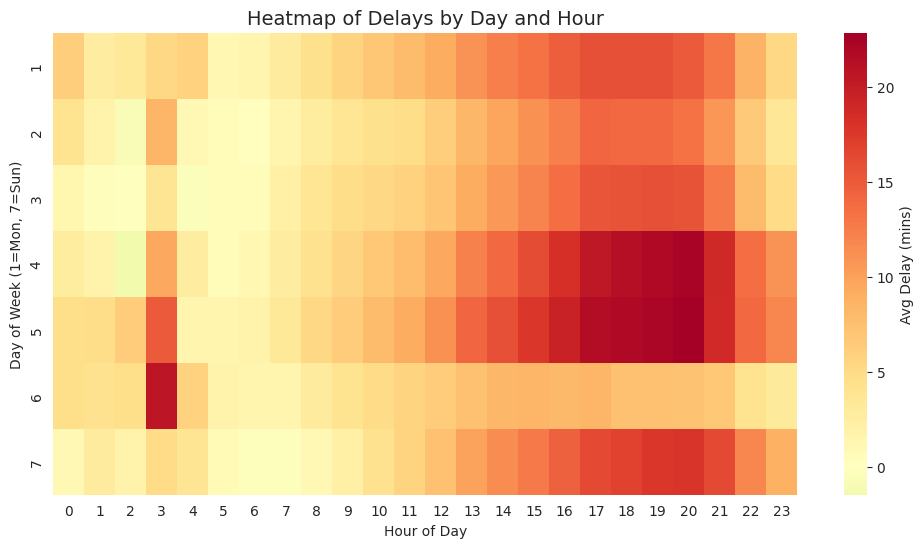

In [8]:
# ==============================================================================
# 2. Time Analysis (Are there specific days/hours with more delays?)
# ==============================================================================
# Create a temporary Hour column for this plot
# Divide by 100 to get the hour from HHMM format
time_df = df_clean.withColumn("DepHour", floor(col("CRSDepTime") / 100))

# Aggregation: Average delay by Day of Week and Hour
heatmap_data = time_df.groupBy("DayOfWeek", "DepHour") \
                      .agg(avg("ArrDelay").alias("AvgDelay")) \
                      .orderBy("DayOfWeek", "DepHour") \
                      .toPandas()

# Heatmap
heatmap_pivot = heatmap_data.pivot(index="DayOfWeek", columns="DepHour", values="AvgDelay")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap="RdYlGn_r", center=0, cbar_kws={'label': 'Avg Delay (mins)'})
plt.title("Heatmap of Delays by Day and Hour", fontsize=14)
plt.ylabel("Day of Week (1=Mon, 7=Sun)")
plt.xlabel("Hour of Day")
plt.show()

/tmp/ipykernel_135891/569426934.py:19: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="AirportType", y="AvgDelay", data=hub_stats, palette="viridis")


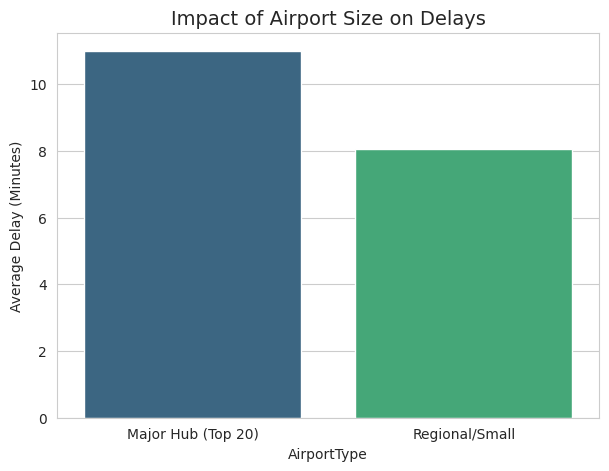

In [9]:
# ==============================================================================
# 3. Location Analysis (Are certain airports more prone to delays?)
# ==============================================================================
# Identify Top 20 Airports by number of departures
top_airports = df_clean.groupBy("Origin").count().orderBy(col("count").desc()).limit(20)
top_20_list = [row["Origin"] for row in top_airports.collect()]

# Tag airports as "Hub" or "Regional"
hub_df = df_clean.withColumn("AirportType", 
                             when(col("Origin").isin(top_20_list), "Major Hub (Top 20)")
                             .otherwise("Regional/Small"))

# Aggregate
hub_stats = hub_df.groupBy("AirportType") \
                  .agg(avg("ArrDelay").alias("AvgDelay")) \
                  .toPandas()

plt.figure(figsize=(7, 5))
sns.barplot(x="AirportType", y="AvgDelay", data=hub_stats, palette="viridis")
plt.title("Impact of Airport Size on Delays", fontsize=14)
plt.ylabel("Average Delay (Minutes)")
plt.show()

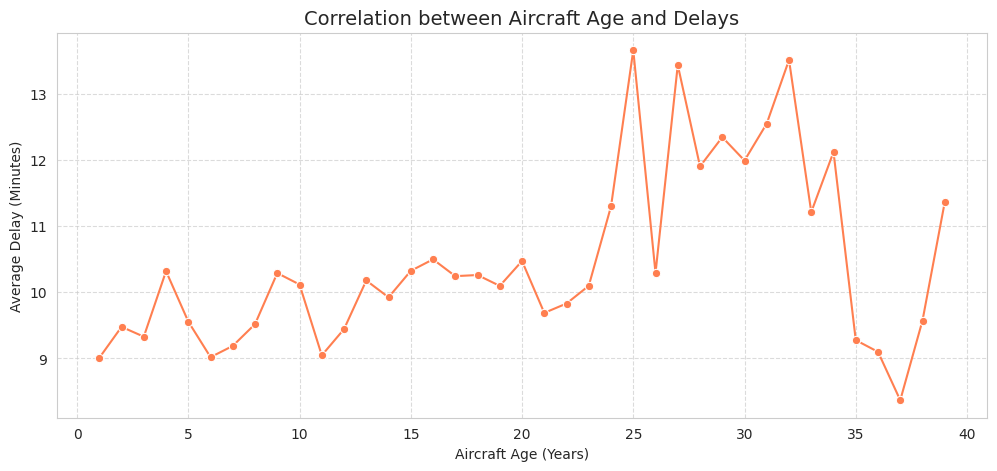

In [10]:
# ==============================================================================
# 4. Mechanic Analysis (Is the Age of the Aircraft correlated with Delays?)
# ==============================================================================
# We perform a temporary join just for this plot to prove 'PlaneAge' is useful
plane_age_df = df_clean.join(df_planes.withColumnRenamed("year", "PlaneYear"), df_clean.TailNum == df_planes.tailnum) \
                       .select((col("Year") - col("PlaneYear").cast("int")).alias("PlaneAge"), "ArrDelay") \
                       .filter((col("PlaneAge") > 0) & (col("PlaneAge") < 40)) # Filter impossible ages

# Aggregate by Age
age_stats = plane_age_df.groupBy("PlaneAge") \
                        .agg(avg("ArrDelay").alias("AvgDelay"), count("*").alias("FlightCount")) \
                        .filter(col("FlightCount") > 100) \
                        .orderBy("PlaneAge") \
                        .toPandas()

plt.figure(figsize=(12, 5))
sns.lineplot(x="PlaneAge", y="AvgDelay", data=age_stats, marker="o", color="coral")
plt.title("Correlation between Aircraft Age and Delays", fontsize=14)
plt.xlabel("Aircraft Age (Years)")
plt.ylabel("Average Delay (Minutes)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

/tmp/ipykernel_135891/331157432.py:32: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="State", y="AvgDelay", data=subset_states, palette="coolwarm")


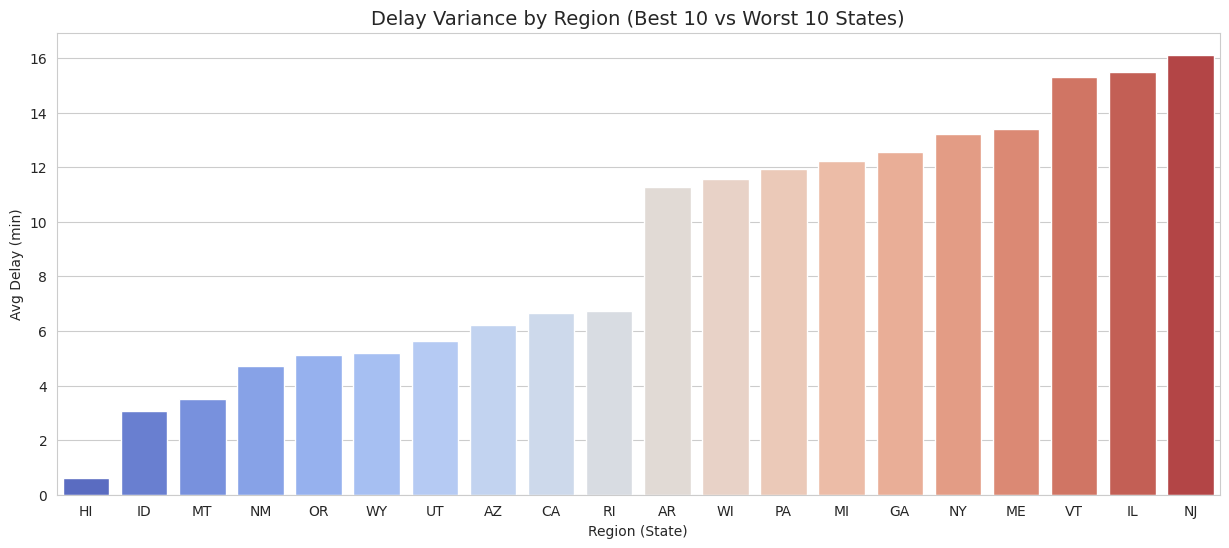

In [11]:
# ==============================================================================
# 5. STATE VS AIRPORT (Dimensionality Reduction)
# ==============================================================================
# Hypothesis: "State" captures enough pattern that we don't need OHE for 300+ airports.

# 1. Join Airport Data to get State/Lat/Long
# We rename columns immediately to avoid ambiguity
airports_eda = df_airports.select(
    col("iata").alias("Code"), 
    col("state").alias("State"), 
    col("lat").alias("Lat"), 
    col("long").alias("Long")
)

# Join just the Origin to simplify the analysis
df_geo = df_clean.join(airports_eda, df_clean.Origin == airports_eda.Code, how="left")

# 2. Aggregation by State
state_stats = df_geo.groupBy("State") \
                    .agg(
                        avg("ArrDelay").alias("AvgDelay"), 
                        count("*").alias("FlightCount")
                    ) \
                    .filter(col("FlightCount") > 1000) \
                    .orderBy("AvgDelay") \
                    .toPandas()

# 3. Plot: State Variance
plt.figure(figsize=(15, 6))
# Show top 10 worst and top 10 best states to show the SPREAD of the data
subset_states = pd.concat([state_stats.head(10), state_stats.tail(10)])
sns.barplot(x="State", y="AvgDelay", data=subset_states, palette="coolwarm")
plt.title("Delay Variance by Region (Best 10 vs Worst 10 States)", fontsize=14)
plt.ylabel("Avg Delay (min)")
plt.xlabel("Region (State)")
plt.show()

+------+-------+
|LatBin|  count|
+------+-------+
|    15|   2540|
|    20| 216756|
|    25| 328708|
|    30|2517832|
|    35|5315229|
|    40|7164575|
|    45| 926328|
|    55|  25947|
|    60|  90454|
|    65|   4755|
|    70|   5087|
+------+-------+



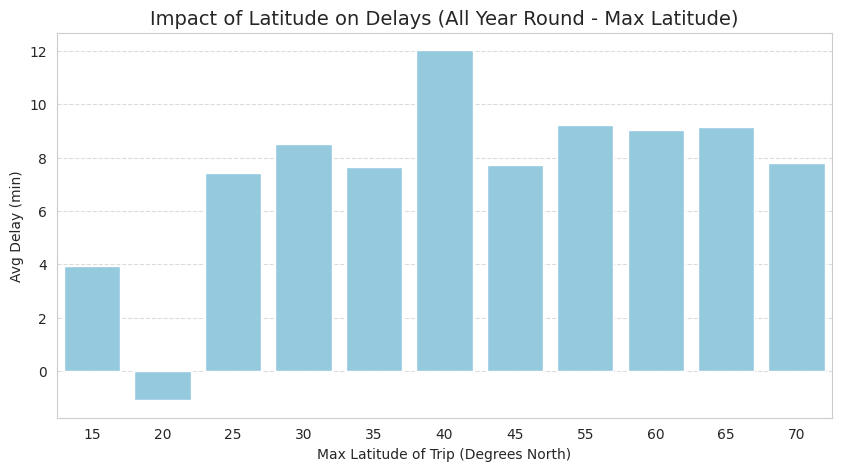

In [12]:
# ==============================================================================
# 6.1 LATITUDE ANALYSIS (All Year Round)
# ==============================================================================
# Hypothesis: Does higher latitude (Origin OR Dest) correlate with delays annually (icier and colder climates)?

# 1. Get Destination Latitude
dest_coords = airports_eda.select(col("Code").alias("DestCode"), col("Lat").alias("DestLat"))
df_all_year = df_geo.join(dest_coords, df_geo.Dest == dest_coords.DestCode, how="left")


# 2. Create 'TripLat' (The Max Latitude of the journey)
# Captures if the flight touches a Northern airport at either end.
df_all_year = df_all_year.withColumn("TripLat", greatest(col("Lat"), col("DestLat")))

# 3. Bin the Max Latitude
df_all_year = df_all_year.withColumn("LatBin", floor(col("TripLat") / 5) * 5)

# 4. Aggregate
lat_stats_all_year = df_all_year.groupBy("LatBin") \
    .agg(avg("ArrDelay").alias("AvgDelay")) \
    .orderBy("LatBin") \
    .toPandas()

df_all_year.groupBy("LatBin").count().orderBy("LatBin").show()

# 5. Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="LatBin", y="AvgDelay", data=lat_stats_all_year, color="skyblue")

plt.title("Impact of Latitude on Delays (All Year Round - Max Latitude)", fontsize=14)
plt.xlabel("Max Latitude of Trip (Degrees North)")
plt.ylabel("Avg Delay (min)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

+------+-------+
|LatBin|  count|
+------+-------+
|    15|    696|
|    20|  57895|
|    25|  91424|
|    30| 693722|
|    35|1466397|
|    40|1955329|
|    45| 247979|
|    55|   5933|
|    60|  20626|
|    65|   1295|
|    70|   1396|
+------+-------+



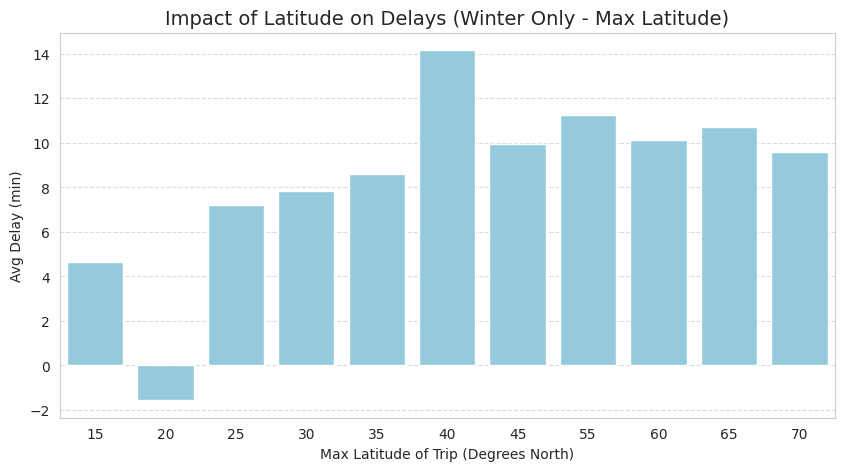

In [13]:
# ==============================================================================
# 6.2 LATITUDE ANALYSIS (Winter Only)
# ==============================================================================
# Hypothesis: Will there be a stronger correlation between latitude and delays in Winter (Dec, Jan, Feb)?

# 1. Filter the EXISTING 'df_all_year' dataframe
# We don't need to join or recalculate TripLat/LatBin; it's already there!
df_winter_max = df_all_year.filter(col("Month").isin([12, 1, 2]))

# 2. Aggregate
lat_stats_winter_max = df_winter_max.groupBy("LatBin") \
    .agg(avg("ArrDelay").alias("AvgDelay")) \
    .orderBy("LatBin") \
    .toPandas()

df_winter_max.groupBy("LatBin").count().orderBy("LatBin").show()

# 3. Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="LatBin", y="AvgDelay", data=lat_stats_winter_max, color="skyblue")

plt.title("Impact of Latitude on Delays (Winter Only - Max Latitude)", fontsize=14)
plt.xlabel("Max Latitude of Trip (Degrees North)")
plt.ylabel("Avg Delay (min)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipykernel_135891/326239565.py:40: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="RiskCategory", y="AvgDelay", data=risk_stats, palette="Reds")


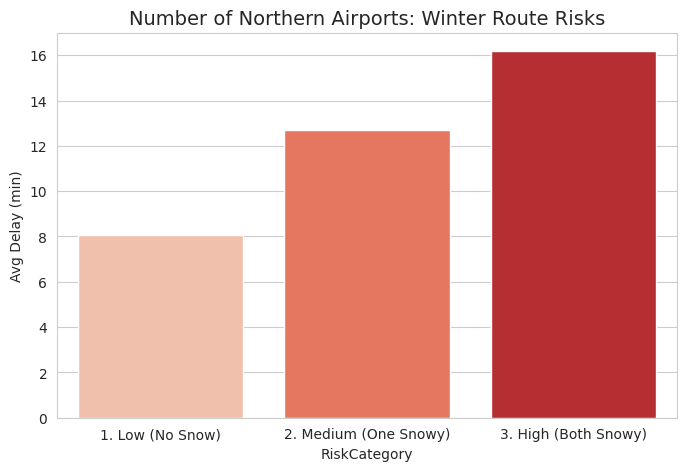

In [14]:
# ==============================================================================
# 6.3 ROUTE RISK PROFILE (Double Northern Airport Test)
# ==============================================================================
# Explanation: Before, we were looking at the MAX latitude of the trip. Now, we
#  will categorize routes based on whether BOTH airports are North of a certain latitude.
#
# Hypothesis: Flights where BOTH airports are North are riskier than just one.


# 1. Define the "Snow Line"
# We chose 40 degrees, as, afters seeing previous charts, and doing some research, this is
#  the latitude of the so called "winter belt" in the US.
SNOW_LINE = 40

# 2. Join Destination Latitude
dest_coords = airports_eda.select(col("Code").alias("DestCode"), col("Lat").alias("DestLat"))
df_risk_cat = df_geo.join(dest_coords, df_geo.Dest == dest_coords.DestCode, how="left")

# 3. Create Categories
# - High Risk: Both Origin AND Dest are > 40
# - Medium Risk: Either Origin OR Dest is > 40 (but not both)
# - Low Risk: Neither is > 40
df_risk_cat = df_risk_cat.withColumn("RiskCategory", 
    when((col("Lat") >= SNOW_LINE) & (col("DestLat") >= SNOW_LINE), "3. High (Both Snowy)")
    .when((col("Lat") >= SNOW_LINE) | (col("DestLat") >= SNOW_LINE), "2. Medium (One Snowy)")
    .otherwise("1. Low (No Snow)")
)

# 4. Filter for Winter Only
df_risk_winter = df_risk_cat.filter(col("Month").isin([12, 1, 2]))

# 5. Aggregate
risk_stats = df_risk_winter.groupBy("RiskCategory") \
    .agg(avg("ArrDelay").alias("AvgDelay")) \
    .orderBy("RiskCategory") \
    .toPandas()

# 6. Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="RiskCategory", y="AvgDelay", data=risk_stats, palette="Reds")
plt.title("Number of Northern Airports: Winter Route Risks", fontsize=14)
plt.ylabel("Avg Delay (min)")
plt.show()

/tmp/ipykernel_135891/4184022485.py:24: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Direction", y="AvgDelay", data=dir_stats, palette="Set2")


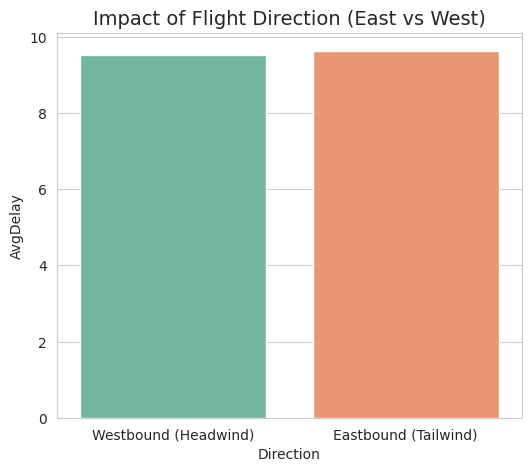

In [15]:
# ==============================================================================
# 7. FLIGHT DIRECTION (Eeast vs. West)
# ==============================================================================
# Explanation: In the US, prevailing winds generally blow from West to East.
#
# Hypothesis: Flying East (Tailwind) recovers time? Flying West (Headwind) loses time?


# We need Destination Longitude to calculate direction
dest_coords = airports_eda.select(col("Code").alias("DestCode"), col("Long").alias("DestLong"))
df_direction = df_geo.join(dest_coords, df_geo.Dest == dest_coords.DestCode, how="left")

# Calculate Difference of Longitude
# Positive = Eastbound, Negative = Westbound
df_direction = df_direction.withColumn("Direction", 
                                       when((col("DestLong") - col("Long")) > 0, "Eastbound (Tailwind)")
                                       .otherwise("Westbound (Headwind)"))

dir_stats = df_direction.groupBy("Direction") \
                        .agg(avg("ArrDelay").alias("AvgDelay")) \
                        .toPandas()

plt.figure(figsize=(6, 5))
sns.barplot(x="Direction", y="AvgDelay", data=dir_stats, palette="Set2")
plt.title("Impact of Flight Direction (East vs West)", fontsize=14)
plt.show()

/tmp/ipykernel_135891/4292291391.py:24: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Direction", y="AvgDelay", data=dir_stats, palette="Set2")


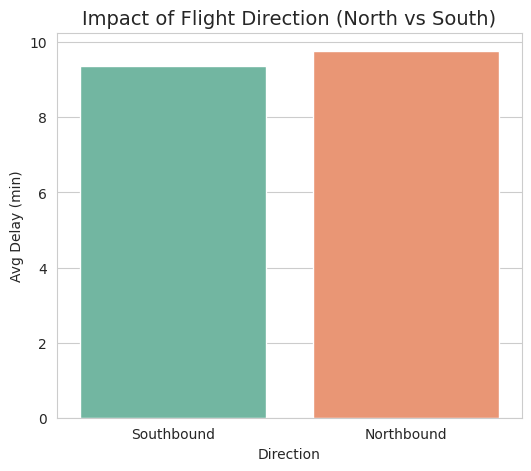

In [16]:
# ==============================================================================
# 8. FLIGHT DIRECTION (North vs. South)
# ==============================================================================
# Hypothesis: Does flying North vs. South impact delays? 

# Get Destination Latitude
dest_coords = airports_eda.select(col("Code").alias("DestCode"), col("Lat").alias("DestLat"))

# Join to get DestLat alongside Origin Lat
df_direction = df_geo.join(dest_coords, df_geo.Dest == dest_coords.DestCode, how="left")

# Calculate Direction based on Latitude
# If DestLat > Origin Lat = Northbound
df_direction = df_direction.withColumn("Direction", 
                                       when((col("DestLat") - col("Lat")) > 0, "Northbound")
                                       .otherwise("Southbound"))

# Plot
dir_stats = df_direction.groupBy("Direction") \
                        .agg(avg("ArrDelay").alias("AvgDelay")) \
                        .toPandas()

plt.figure(figsize=(6, 5))
sns.barplot(x="Direction", y="AvgDelay", data=dir_stats, palette="Set2")
plt.title("Impact of Flight Direction (North vs South)", fontsize=14)
plt.ylabel("Avg Delay (min)")
plt.show()

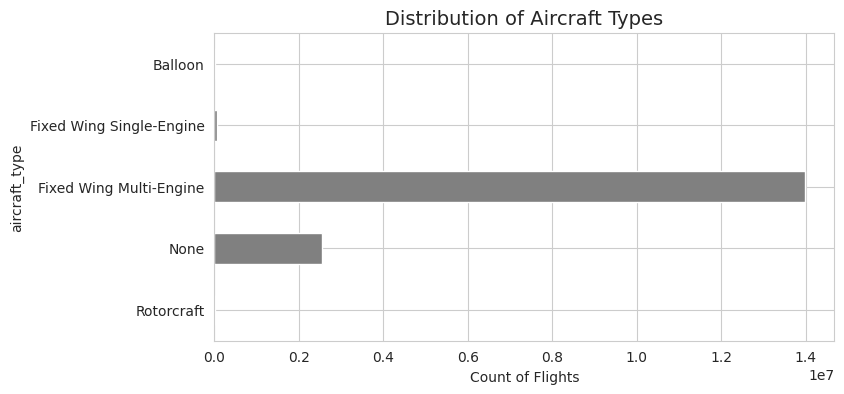

/tmp/ipykernel_135891/1003955263.py:25: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="manufacturer", x="count", data=top_makers, palette="muted")


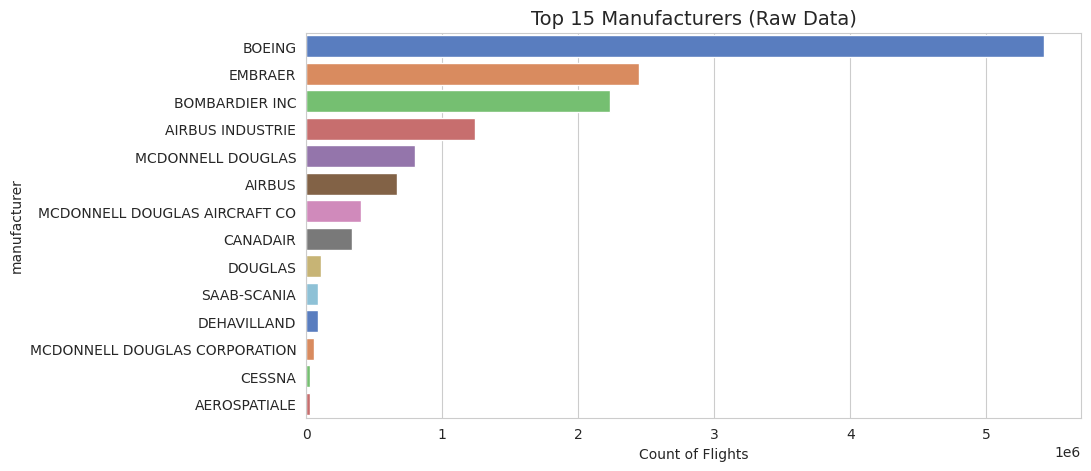

/tmp/ipykernel_135891/1003955263.py:35: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="engine_type", y="AvgDelay", data=engine_stats, palette="coolwarm")


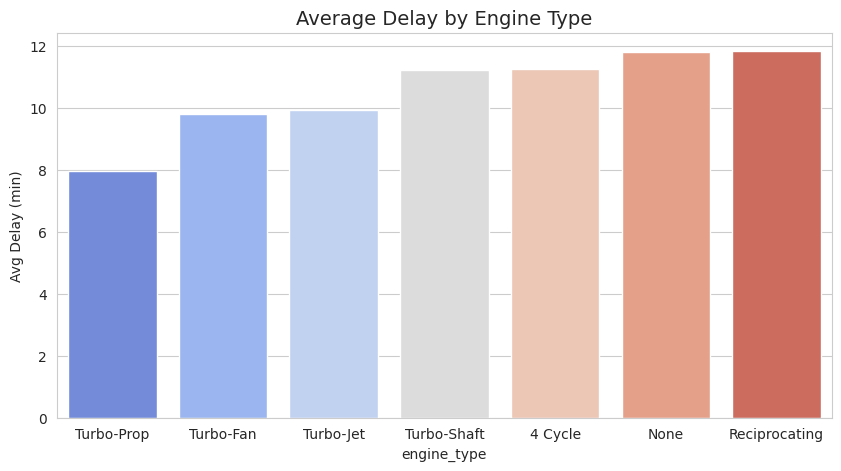

In [22]:
# ==============================================================================
# 9. AIRCRAFT METADATA ANALYSIS
# ==============================================================================
# Objective: Evaluate the utility of aircraft features.
# - Identify low-variance columns (drop).
# - Detect inconsistent labeling (clean).
# - Verify correlation with delays (keep).

# Join flight data with plane metadata for this analysis
df_planes_eda = df_clean.join(df_planes, df_clean.TailNum == df_planes.tailnum, how="left") 

# 1. Aircraft Type Distribution
# Checking for variance. If dominated by a single category, the feature is non-predictive.
plt.figure(figsize=(8, 4))
df_planes_eda.groupBy("aircraft_type").count().toPandas().set_index("aircraft_type")['count'].plot(kind='barh', color='grey')
plt.title("Distribution of Aircraft Types", fontsize=14)
plt.xlabel("Count of Flights")
plt.show()

# 2. Manufacturer Consistency
# Inspecting the top labels to check for data quality issues (e.g., 'Airbus' vs 'Airbus Industrie')
top_makers = df_planes_eda.groupBy("manufacturer").count().orderBy(col("count").desc()).limit(15).toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(y="manufacturer", x="count", data=top_makers, palette="muted")
plt.title("Top 15 Manufacturers (Raw Data)", fontsize=14)
plt.xlabel("Count of Flights")
plt.show()

# 3. Engine Type Performance
# Investigating if propulsion type (e.g., Turbo-Prop vs. Fan) correlates with delays
engine_stats = df_planes_eda.groupBy("engine_type").agg(avg("ArrDelay").alias("AvgDelay")).orderBy("AvgDelay").toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(x="engine_type", y="AvgDelay", data=engine_stats, palette="coolwarm")
plt.title("Average Delay by Engine Type", fontsize=14)
plt.ylabel("Avg Delay (min)")
plt.show()

/tmp/ipykernel_135891/3996706016.py:15: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Month", y="AvgDelay", data=monthly_stats, palette="viridis")


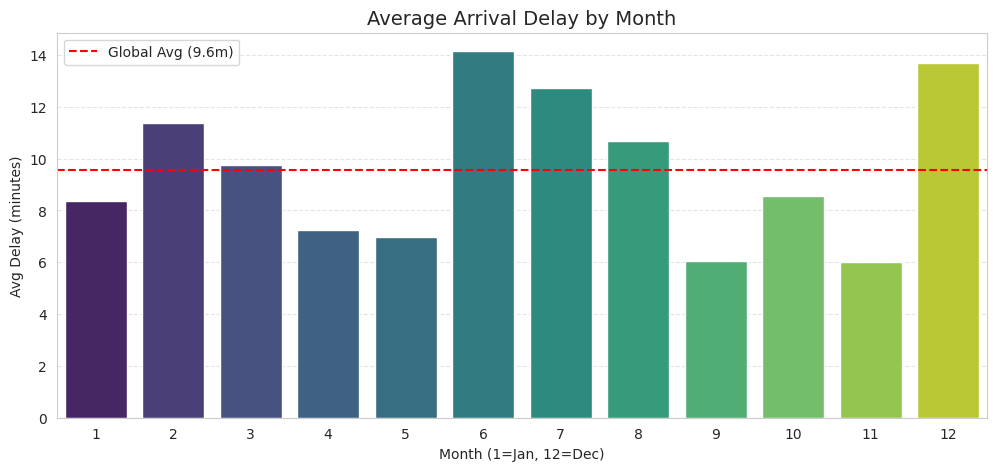

In [ ]:
# ==============================================================================
# 10. MONTH VALIDATION (Should we drop it?)
# ==============================================================================

# 1. Aggregate Delay by Month
monthly_stats = df_geo.groupBy("Month") \
                      .agg(avg("ArrDelay").alias("AvgDelay")) \
                      .orderBy("Month") \
                      .toPandas()

# 2. Plot
plt.figure(figsize=(12, 5))
sns.barplot(x="Month", y="AvgDelay", data=monthly_stats, palette="viridis")
plt.title("Average Arrival Delay by Month", fontsize=14)
plt.ylabel("Avg Delay (minutes)")
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add a horizontal line for the global average to see which months are "Riskier"
global_avg = df_geo.select(avg("ArrDelay")).first()[0]
plt.axhline(y=global_avg, color='red', linestyle='--', label=f"Global Avg ({global_avg:.1f}m)")
plt.legend()
plt.show()

Calculating correlation for 11 variables...


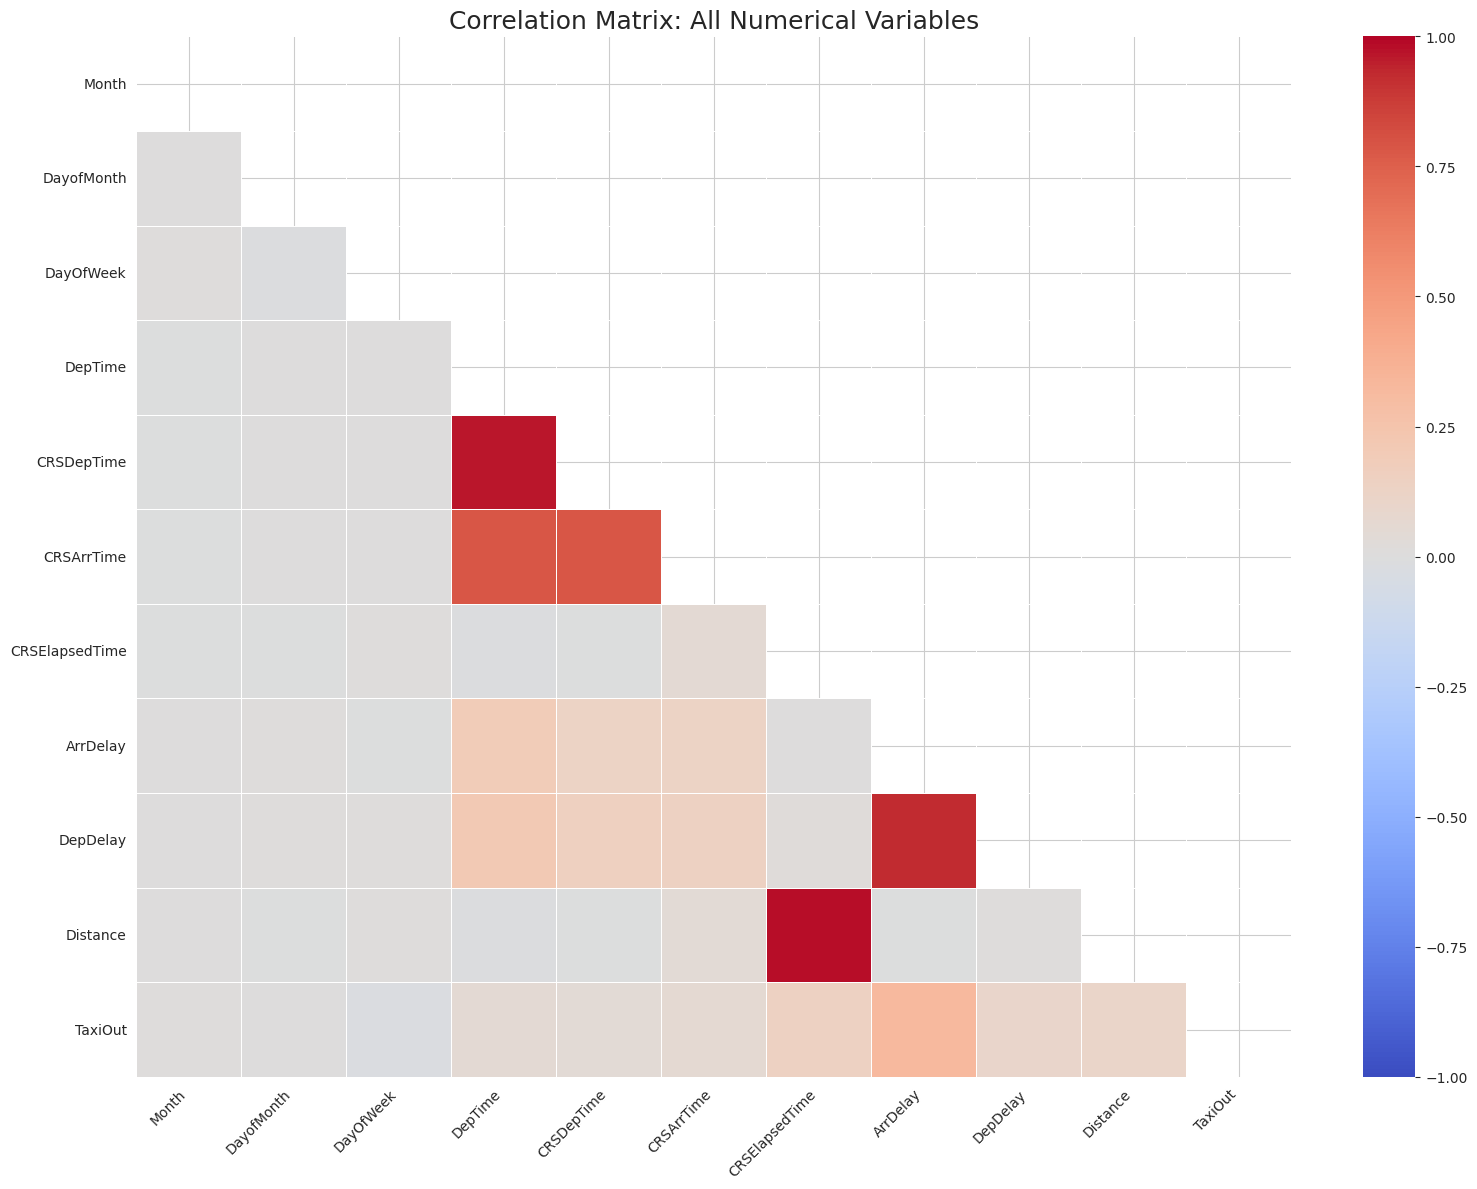

In [ ]:
# ==============================================================================
# 11. FULL CORRELATION MATRIX (All Numerical Variables)
# ==============================================================================

# 1. Identify all numerical columns dynamically
# (We exclude 'Year' because it is constant 2008 and breaks the correlation calc)
numeric_cols = [t[0] for t in df_clean.dtypes 
                if t[1] in ['int', 'double', 'float', 'bigint', 'long'] 
                and t[0] not in ['Year', 'FlightNum', 'Cancelled', 'Diverted']]

print(f"Calculating correlation for {len(numeric_cols)} variables...")

# 2. Sample the data (10% is usually enough for a stable correlation)
# We convert to Pandas because Spark's native correlation is harder to plot
df_sample = df_clean.select(numeric_cols).sample(fraction=0.1, seed=42).toPandas()

# 3. Calculate Correlation Matrix
corr_matrix = df_sample.corr()

# 4. Plot the Grand Heatmap
plt.figure(figsize=(16, 12)) # Huge size for all variables
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Hide the upper triangle (redundant)

sns.heatmap(corr_matrix, 
            annot=False,     # Turn off numbers (too messy for 25+ vars)
            cmap='coolwarm', # Red = Positive, Blue = Negative
            mask=mask, 
            vmin=-1, vmax=1, 
            linewidths=0.5)

plt.title("Correlation Matrix: All Numerical Variables", fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Conclusion of EDA
Having done the exploratory data analysis, it is time to analyze and interpret the results:

#### 1. Distribution of Arrival Delays
From looking at the distribution of arrival delays, we can see that most flights arrive on time or with minimal delays. However, there is a long tail of significant delays, indicating that while rare, extreme delays do occur. This suggests that while our model should focus on predicting small to moderate delays, it should also be robust enough to handle outliers.

Based on this distribution, we filtered our model selection:

- Discarded: `Isotonic Regression` (univariate only), `Survival Regression` (data is not censored), and `Factorization Machines` (optimized for sparse data, not dense records).

- The Linear Baseline: We retain `standard Linear Regression` strictly as a baseline. While the heavy skew and non-normal errors violate its core assumptions, it serves as a benchmark to measure the performance gain of more complex models.

- Selected Candidates: We will prioritize Tree-based models (`Decision Tree`, `Random Forest`, and `GBT`). Their non-linear structure is naturally suited for the 'long tail' distribution and can better capture the interaction effects (e.g., Winter + High Latitude) that a simple linear equation would miss."

#### 2. Delays by day of the week and hour
The heatmap analysis reveals clear patterns in delays based on the day of the week and time of day. Peak delays tend to occur between 15:00 and 21:00 hours, particularly on Thursdays and Fridays. We find that Saturdays are an exception to this trend, showing high delays at 03:00.

#### 3. Impact of airport size on the delay
The result is clear, Hubs show an average delay of around 3 minutes more than regular airports.

#### 4. Correlation between aircraft age and delays
Despite expecting a more linear relationship, the result proves a bit erratic. Planes between 0 and 23 years show average delays ranging between 9 and 10.5 minutes. However, after that, the result gets more erratic. A possible explanation would be that, after the average life, the planes that remain are only the best ones (survivor bias) and are assigned lighter tasks.

#### 5. Delay variance by state
The main purpose of this analysis is to know if we can swap the airport name for the state, as it would help us reduce the dimensionality a lot (from around 3000 airports to 50 states). Luckily, the results support this, we can see a clear difference between states.

*IMPORTANT NOTE: Exclusively swapping the airport name for the state risks information loss, as a single state often hosts both congested hubs and smaller regional airfields. Using the "Airport Size" variable helps solve this. By combining State with Airport Type, we can successfully reduce dimensionality without losing the ability to differentiate between major hubs and smaller airports.*

#### 6. Impact of the latitude on delays (North -> Ice -> Delays?)
With this series of visualizations we try to determine if airports in higher latitudes show higher delays due to harsh conditions such as ice and snow.

##### 6.1 All year round
We can see two main tendencies:
- There is a large spike at latitude 40. The explanation for this is that in this latitude we have some of the major hubs in the US: Chicago, New York, Philadelphia, Denver and San Francisco.
- There is a small increase in higher latitudes compared to lower ones.

##### 6.2 Only winter
In order to check if that small differences between higher and lower latitudes was washed away by averaging with hotter periods like summer, we focus mainly on winter months (December, January and February):
- The spike at latitude 40 is more prevalent now.
- We see an increase in the difference between higher and lower latitudes. Now it is more noticeable.

##### 6.3 Number of airports with high latitude
Until this point we have only been using the maximum latitude between origin and destination airport. However, it is also interesting to know if there is a noticeable difference between having 1 airport at high latitude (over 40°), 2 or none. The result is clear, having both airports at higher latitudes leads to an average delay twice the size of having none.

#### 7-8. Impact of the flight direction (East vs. West and North vs. South)
Both comparisons show almost the exact same value. A possible explanation would be airlines already taking this into account when assigning the scheduled arrival time and padding for it.

#### 9. Aircraft metadata analysis
Variables `type`, `issue_date` and `status` have not been analyzed because they either hold the same value almost always (`type` and `status`) or are not of true interest (`issue_date`). The `model` variable, while very interesting would add too much dimensionality to the model, making it non-viable. Regarding `aircraft_type`, `manufacturer` and `engine_type`, the results are what we expected. 
- `aircraft_type` proved to be useless, almost all planes have the same value here: "Fixed Wing Multi-Engine". 
- `manufacturer` is quite messy but shows enough variability. We can see values like AIRBUS INDUSTRIE and AIRBUS, so some cleaning will be needed in the following section.
- `engine_type` will not be very useful as it does not show a lot of variance. It also should be mentioned that it is already covered by Age and Manufacturer.

#### 10. Average delay per month
We can see the delays are concentrated around 2 time periods, summer and winter (Christmas). Identified these specific spikes,  the Month is less important than knowing if we are in one of these periods.

#### 11. Correlation Matrix
The matrix confirms a near-perfect positive relationship between `DepDelay` and `ArrDelay`, verifying that departure delays are the primary driver of arrival delays. We also observe significant multicollinearity between physical constants (e.g., `Distance` vs. `CRSElapsedTime`) and between scheduled and actual times (`CRSDepTime` vs. `DepTime`). To avoid redundancy and instability in our models, we must avoid including these highly correlated pairs simultaneously. Finally, the complete lack of linear correlation between delays and calendar variables (Month, DayOfWeek) reinforces that these act as cyclical or categorical factors rather than continuous numerical predictors.

## Feature Engineering

Moving on from EDA to Feature Engineering, here is a summary of the changes we will be doing to the dataset we will feed our models.

*Note: The forbidden variables (`ArrTime`, `ActualElapsedTime`, `AirTime`, `TaxiIn`, `Diverted`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, `CancellationCode`) and `Cancelled` rows were already dropped during the Cleaning phase.*

#### Dropping/Not including

* `aircraft_type`: Not included. (Zero variance; 99% are "Fixed Wing Multi-Engine").

* `model`: Not included. (Too high cardinality; 167+ models, many with <10 flights).

* `engine_type`: Not included. (Redundant; variance is already explained by `AgeBin` and `Manufacturer`).

* `Origin` / `Dest` (Airport Codes): Dropped. (Replaced by `OriginState` and `Origin_IsHub` to reduce dimensions).

* `Lat` / `Long` (Raw): Not included. (Replaced by `TripMaxLat` to specifically target snow zones).

* `Direction` (N/S, E/W): Not included. (EDA showed no impact; airlines pad schedules for wind).

* `FlightNum` / `TailNum`: Dropped. (Random identifiers with no numerical or predictive meaning).

* `Year` / `DayofMonth` / `Month`: Dropped. (Year is constant for 2008; DayofMonth adds noise without capturing Holiday trends) and Month will be transformed into two new flags `IsSummer` and `IsWinter`.

- `DepTime`: Dropped. (Redundant; it is `CRSDepTime` + `DepDelay`. We already include both components).

- `CRSElapsedTime`: Dropped. (Redundant; highly correlated with Distance as shown in the matrix).

- `CRSArrTime`: Dropped. (Redundant. We have DepHour + Distance).

#### Adding/Making

* `Manufacturer_Clean`: New Feature. Groups into Top 5 (Boeing, Airbus, Embraer, Bombardier, MD) + "Other".

* `AgeBin`: New Feature. Categorical (New, Mid-Life, Legacy) to capture the "Bathtub Curve" non-linearity.

* `Origin_IsHub` / `Dest_IsHub`: New Feature. Binary (1 if Origin is in Top 20 busiest airports).

* `OriginState` / `DestState`: New Feature. Replaces the high-cardinality Airport Code with the State region.

* `DepHour`: Transformed. Extracts integer hour from `CRSDepTime` (e.g., 1430 → 14) to capture the "Rush Hour" effect.

* `IsWinter`: New Feature. Binary flag (Dec, Jan, Feb) to capture seasonality.

- `IsSummer`: New Feature. Binary flag (Jun, Jul, Aug) to capture vacation traffic and thunderstorm risks. (Added based on EDA showing high average delays in these months).

* `TripMaxLat`: Derived. The maximum latitude of the route. Captures if a flight enters the snow zone, even if it started in the South.

- `IceRisk`: Interaction Term. (1 if `IsWinter`=True AND `TripMaxLat` > 40°). Captures the "Double Jeopardy" effect.

#### Keeping (Critical Predictors)

- `DepDelay`: Kept. (Known at takeoff; the strongest predictor of arrival delay). 

- `TaxiOut`: Kept. (Known at takeoff; captures ground congestion at the origin).

- `UniqueCarrier`: Kept. (Operational efficiency varies by airline).

- `Distance`: Kept. (Physics constraint).

- `DayOfWeek`: Kept. (Captures weekly cycles like Monday business rush vs. Saturday lull).

- `ArrDelay`: Kept. (The Target variable).



In [6]:
# ==============================================================================
# Data Engineering (ETL for Feature Creation)
# ==============================================================================

# ------------------------------------------------------------------------------
# 1. SETUP & LOADS
# ------------------------------------------------------------------------------
# Reload auxiliary data to ensure clean state
# (Assumes 'plane-data.csv' and 'airports.csv' are in your path)
df_planes_raw = spark.read.option("header", "true").option("inferSchema", "true").csv(planeFilePath)
df_planes_sel = df_planes_raw.select(
    col("tailnum"), 
    col("year").alias("year_manufactured"), 
    col("manufacturer")
)

# Identify Hubs (Top 20 Airports by Volume from our clean data)
top_airports = df_clean.groupBy("Origin").count().orderBy(col("count").desc()).limit(20)
hub_list = [row['Origin'] for row in top_airports.collect()] 

# Prepare Airport Meta
# (We reload this to ensure we have the raw Lat/State data)
df_airports_raw = spark.read.option("header", "true").option("inferSchema", "true").csv(airportFilePath)
airports_meta = df_airports_raw.select(
    col("iata").alias("Code"),
    col("lat").alias("Lat"),
    col("state").alias("State")
).distinct()

# ------------------------------------------------------------------------------
# 2. JOINS
# ------------------------------------------------------------------------------

# Join Origin
df_feat = df_clean.join(airports_meta, df_clean.Origin == airports_meta.Code, how="left") \
    .withColumnRenamed("Lat", "OriginLat") \
    .withColumnRenamed("State", "OriginState") \
    .drop("Code")

# Join Destination
dest_meta = airports_meta.select(col("Code").alias("DestCode"), col("Lat").alias("DestLat"), col("State").alias("DestState"))
df_feat = df_feat.join(dest_meta, df_feat.Dest == dest_meta.DestCode, how="left").drop("DestCode")

# Join Planes
df_feat = df_feat.join(df_planes_sel, df_feat.TailNum == df_planes_sel.tailnum, how="left")

# ------------------------------------------------------------------------------
# 3. TRANSFORMATIONS
# ------------------------------------------------------------------------------

# Time: Extract Hour
df_feat = df_feat.withColumn("DepHour", floor(col("CRSDepTime") / 100))

# Seasonality: Winter & Summer
df_feat = df_feat.withColumn("IsWinter", when(col("Month").isin([12, 1, 2]), 1).otherwise(0))
df_feat = df_feat.withColumn("IsSummer", when(col("Month").isin([6, 7, 8]), 1).otherwise(0))

# Weather Risk: Ice (Winter + High Lat)
df_feat = df_feat.withColumn("TripMaxLat", greatest(col("OriginLat"), col("DestLat")))
df_feat = df_feat.withColumn("IceRisk", 
    when((col("IsWinter") == 1) & (col("TripMaxLat") >= 40), 1).otherwise(0)
)

# Network: Hubs
df_feat = df_feat.withColumn("Origin_IsHub", when(col("Origin").isin(hub_list), 1).otherwise(0))
df_feat = df_feat.withColumn("Dest_IsHub", when(col("Dest").isin(hub_list), 1).otherwise(0))

# Asset: Clean Manufacturer
df_feat = df_feat.withColumn("Manufacturer_Clean", 
    when(col("manufacturer").like("%AIRBUS%"), "AIRBUS")
    .when(col("manufacturer").like("%BOEING%"), "BOEING")
    .when(col("manufacturer").like("%BOMBARDIER%"), "BOMBARDIER")
    .when(col("manufacturer").like("%EMBRAER%"), "EMBRAER")
    .when(col("manufacturer").like("%MCDONNELL%"), "MCDONNELL_DOUGLAS")
    .otherwise("OTHER")
)

# Asset: Age Bins
df_feat = df_feat.withColumn("PlaneAge", col("year").cast("int") - col("year_manufactured"))
median_age = df_feat.approxQuantile("PlaneAge", [0.5], 0.01)[0]
df_feat = df_feat.fillna(median_age, subset=["PlaneAge"])

bucketizer = Bucketizer(splits=[-float("inf"), 23, 33, float("inf")], inputCol="PlaneAge", outputCol="AgeBin")
df_feat = bucketizer.transform(df_feat)
df_model = df_feat.fillna({'AgeBin': -1})

# ------------------------------------------------------------------------------
# 4. FINAL SELECTION
# ------------------------------------------------------------------------------

final_columns = [
    "ArrDelay",           # Target
    "DepDelay",           # Predictor
    "TaxiOut",            # Predictor
    "DepHour",            # Time
    "DayOfWeek",          # Time
    "UniqueCarrier",      # Carrier
    "OriginState",        # Geo
    "DestState",          # Geo
    "Origin_IsHub",       # Network
    "Dest_IsHub",         # Network
    "IsWinter",           # Seasonality
    "IsSummer",           # Seasonality
    "IceRisk",            # Weather
    "AgeBin",             # Asset
    "Manufacturer_Clean", # Asset
    "Distance"            # Physics
]

df_model = df_model.select(final_columns).dropna()

# 80% Training, 20% Testing
train_raw, test_raw = df_model.randomSplit([0.8, 0.2], seed=42)

# Cache to speed up the next Training step
train_raw.cache()
test_raw.cache()

df_model.persist()

# Save the ETL result so we don't have to re-run the joins
df_model.write.mode("overwrite").parquet("data/df_model_clean.parquet")

# Reload it to ensure a clean, optimized execution plan
df_model = spark.read.parquet("data/df_model_clean.parquet")

df_model.show(5)

+--------+--------+-------+-------+---------+-------------+-----------+---------+------------+----------+--------+--------+-------+------+------------------+--------+
|ArrDelay|DepDelay|TaxiOut|DepHour|DayOfWeek|UniqueCarrier|OriginState|DestState|Origin_IsHub|Dest_IsHub|IsWinter|IsSummer|IceRisk|AgeBin|Manufacturer_Clean|Distance|
+--------+--------+-------+-------+---------+-------------+-----------+---------+------------+----------+--------+--------+-------+------+------------------+--------+
|   140.0|   140.0|   20.0|     20|        1|           AA|         IL|       MD|           1|         1|       0|       1|      0|   0.0|             OTHER|   622.0|
|    38.0|    40.0|   15.0|     20|        2|           AA|         IL|       MD|           1|         1|       0|       1|      0|   0.0| MCDONNELL_DOUGLAS|   622.0|
|   177.0|   197.0|   10.0|     20|        4|           AA|         IL|       MD|           1|         1|       0|       1|      0|   0.0|             OTHER|   622.0

### Pipeline Architecture
To keep the model clean and manageable while handling the 13.2 million records, we built a specific architecture designed for both speed and interpretability:

1. Categorical Mapping: We used StringIndexer and OneHotEncoder (OHE) for variables like Carrier, State, and Manufacturer. By setting handleInvalid="keep", we ensure the model assigns any unknown labels in the test set to a special "extra" bucket instead of crashing the process.

2. Dimensionality Reduction: Following our EDA finding, we swapped thousands of individual airport names for 50 States and a binary Hub Status variable. This reduced our features significantly without losing the critical "Hub" signal identified earlier.

3. The VectorAssembler: This stage combines our OHE vectors with our numerical predictors—including DepDelay, TaxiOut, Distance, and IceRisk—into a single master feature vector required by the Spark MLlib algorithms.

4. The Scaler (StandardScaler): This is the most important "device" in the pipeline. We scaled every feature to have a mean of 0 and a standard deviation of 1. This was mandatory because variables like Distance (which goes into the thousands) would otherwise numerically bully variables like IceRisk (small decimals). Now, every weight in our results is on a level playing field, allowing for the direct comparisons seen in our FIA.


In [7]:
# ==============================================================================
# ML Pipeline: Indexing, One-Hot Encoding & Vector Assembling
# ==============================================================================

print("Preparing Data for Training (Index -> OHE -> Vector)...")

# ------------------------------------------------------------------------------
# A. DEFINE COLUMNS
# ------------------------------------------------------------------------------

# 1. Categorical Columns (To be One-Hot Encoded)
cat_cols = ["UniqueCarrier", "OriginState", "DestState", "Manufacturer_Clean", "AgeBin"]
# Note: AgeBin is technically categorical (0, 1, 2), so OHE is safer than treating it as linear.

# 2. Numerical Columns (Go straight to Assembler)
num_cols = [
    "DepDelay", "TaxiOut", "DepHour", "DayOfWeek", "Distance", 
    "Origin_IsHub", "Dest_IsHub", "IsWinter", "IsSummer", "IceRisk"
]

# ------------------------------------------------------------------------------
# B. BUILD PIPELINE STAGES
# ------------------------------------------------------------------------------
stages = []

# Stage 1: StringIndexer (String -> Index)
# Converts "United Airlines" -> 0, "Delta" -> 1
# handleInvalid="keep" puts nulls/unknowns into a special "extra" bucket
for c in cat_cols:
    indexer = StringIndexer(inputCol=c, outputCol=f"{c}_Idx", handleInvalid="keep")
    stages.append(indexer)

# Stage 2: OneHotEncoder (Index -> Vector)
# Converts 1 -> [0, 1, 0, ...] (Prevents "2 is greater than 1" logic)
# We loop through the SAME list to encode the indices we just created
ohe_inputs = [f"{c}_Idx" for c in cat_cols]
ohe_outputs = [f"{c}_Vec" for c in cat_cols]

encoder = OneHotEncoder(inputCols=ohe_inputs, outputCols=ohe_outputs)
stages.append(encoder)

# Stage 3: VectorAssembler (Combine All)
# We use the OHE Vectors + the original Numerical columns
assembler_inputs = ohe_outputs + num_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="unscaled_features")
stages.append(assembler)

# Stage 4: StandardScaler
# We scale the features so that Distance (large) and IsWinter (small) 
# are treated fairly by the Regularization logic.
scaler = StandardScaler(
    inputCol="unscaled_features", 
    outputCol="features",
    withStd=True, 
    withMean=True
)
stages.append(scaler)

Preparing Data for Training (Index -> OHE -> Vector)...


## Model Training

### Model Selection and Strategy
Based on our Exploratory Data Analysis, we observed that flight delays follow a highly skewed long tail distribution with complex, non-linear interactions, such as the compounding effect of winter weather at hub airports. Therefore, we selected the following candidate models to be trained:

- Linear Regression Role: Benchmark. Justification: While we expect it to underperform due to the non-linear nature of weather and congestion, it provides a necessary baseline. If a complex model cannot beat the Linear Regression by a significant margin, it is not worth the computational cost.

- Decision Tree Regressor Role: Simple Non-Linear. Justification: Capable of capturing conditional logic, such as delays caused by specific airports during snow. It is interpretable but prone to overfitting.

- Random Forest Regressor Role: Robust Non-Linear (Ensemble). Justification: By averaging many trees, it reduces the variance of a single Decision Tree. It is our primary candidate for the optimal model because it handles categorical variables and outliers robustly without heavy preprocessing.

- Gradient-Boosted Trees (GBT) Role: High-Performance Non-Linear. Justification: Often provides the highest accuracy by correcting errors sequentially. However, it is computationally expensive and harder to tune than Random Forest.

In [8]:
print("Starting Model Training via Pipelines...")
start_total = time.time()

# ------------------------------------------------------------------------------
# MODEL A: LINEAR REGRESSION (Baseline)
# ------------------------------------------------------------------------------
print("Training Linear Regression...")
lr = LinearRegression(featuresCol="features", labelCol="ArrDelay")
pipeline_lr = Pipeline(stages=stages + [lr])
# Fit the pipeline
model_lr = pipeline_lr.fit(train_raw) 
print("  > Linear Regression pipeline trained.")

# ------------------------------------------------------------------------------
# MODEL B: DECISION TREE (Simple Non-Linearity)
# ------------------------------------------------------------------------------
print("Training Decision Tree (Max Depth=5)...")
dt = DecisionTreeRegressor(featuresCol="features", labelCol="ArrDelay", maxDepth=5)
pipeline_dt = Pipeline(stages=stages + [dt])
model_dt = pipeline_dt.fit(train_raw)
print("  > Decision Tree pipeline trained.")

# ------------------------------------------------------------------------------
# MODEL C: RANDOM FOREST (Robust Ensemble - Parallel)
# ------------------------------------------------------------------------------
print("Training Random Forest (20 Trees)...")
rf = RandomForestRegressor(featuresCol="features", labelCol="ArrDelay", numTrees=20, maxDepth=5)
pipeline_rf = Pipeline(stages=stages + [rf])
model_rf = pipeline_rf.fit(train_raw)
print("  > Random Forest pipeline trained.")

# ------------------------------------------------------------------------------
# MODEL D: GRADIENT BOOSTED TREE (High Accuracy - Sequential)
# ------------------------------------------------------------------------------
print("Training GBT Regressor (Iterative)...")
gbt = GBTRegressor(featuresCol="features", labelCol="ArrDelay", maxIter=10, maxDepth=5)
pipeline_gbt = Pipeline(stages=stages + [gbt])
model_gbt = pipeline_gbt.fit(train_raw)
print("  > GBT pipeline trained.")

# ------------------------------------------------------------------------------
# TIMING REPORT
# ------------------------------------------------------------------------------
end_total = time.time()
print(f"\nAll 4 pipelines trained successfully in {end_total - start_total:.1f} seconds.")

Starting Model Training via Pipelines...
Training Linear Regression...


26/01/02 13:00:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
26/01/02 13:00:54 WARN Instrumentation: [da48960a] regParam is zero, which might cause numerical instability and overfitting.
26/01/02 13:01:56 WARN Instrumentation: [da48960a] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


  > Linear Regression pipeline trained.
Training Decision Tree (Max Depth=5)...


26/01/02 13:04:52 WARN MemoryStore: Not enough space to cache rdd_278_7 in memory! (computed 553.8 MiB so far)
26/01/02 13:04:52 WARN MemoryStore: Not enough space to cache rdd_278_4 in memory! (computed 553.8 MiB so far)
26/01/02 13:04:52 WARN MemoryStore: Not enough space to cache rdd_278_2 in memory! (computed 553.8 MiB so far)
26/01/02 13:04:52 WARN MemoryStore: Not enough space to cache rdd_278_0 in memory! (computed 553.8 MiB so far)
26/01/02 13:04:52 WARN BlockManager: Persisting block rdd_278_0 to disk instead.
26/01/02 13:04:52 WARN BlockManager: Persisting block rdd_278_4 to disk instead.
26/01/02 13:04:52 WARN BlockManager: Persisting block rdd_278_2 to disk instead.
26/01/02 13:04:52 WARN BlockManager: Persisting block rdd_278_7 to disk instead.
26/01/02 13:04:52 WARN MemoryStore: Not enough space to cache rdd_278_6 in memory! (computed 553.8 MiB so far)
26/01/02 13:04:52 WARN BlockManager: Persisting block rdd_278_6 to disk instead.
26/01/02 13:04:52 WARN MemoryStore: Not 

  > Decision Tree pipeline trained.
Training Random Forest (20 Trees)...


26/01/02 13:07:35 WARN MemoryStore: Not enough space to cache rdd_361_7 in memory! (computed 536.0 MiB so far)
26/01/02 13:07:35 WARN BlockManager: Persisting block rdd_361_7 to disk instead.
26/01/02 13:07:36 WARN MemoryStore: Not enough space to cache rdd_361_4 in memory! (computed 536.0 MiB so far)
26/01/02 13:07:36 WARN BlockManager: Persisting block rdd_361_4 to disk instead.
26/01/02 13:07:36 WARN MemoryStore: Not enough space to cache rdd_361_6 in memory! (computed 536.0 MiB so far)
26/01/02 13:07:36 WARN BlockManager: Persisting block rdd_361_6 to disk instead.
26/01/02 13:07:36 WARN MemoryStore: Not enough space to cache rdd_361_8 in memory! (computed 536.0 MiB so far)
26/01/02 13:07:36 WARN BlockManager: Persisting block rdd_361_8 to disk instead.
26/01/02 13:07:36 WARN MemoryStore: Not enough space to cache rdd_361_11 in memory! (computed 536.0 MiB so far)
26/01/02 13:07:36 WARN BlockManager: Persisting block rdd_361_11 to disk instead.
26/01/02 13:07:36 WARN MemoryStore: No

  > Random Forest pipeline trained.
Training GBT Regressor (Iterative)...


26/01/02 13:12:57 WARN MemoryStore: Not enough space to cache rdd_449_11 in memory! (computed 527.4 MiB so far)
26/01/02 13:12:57 WARN BlockManager: Persisting block rdd_449_11 to disk instead.


  > GBT pipeline trained.

All 4 pipelines trained successfully in 1176.4 seconds.


## Evaluation & Saving

### Model Evaluation and Validation Strategy

To ensure the model is robust and generalizable, we performed a multi-metric evaluation on a held-out test set, representing 20% of the original data. We justified our validation using the following metrics:

- RMSE (Root Mean Squared Error): This is our primary metric. It expresses error in the original units (minutes) while penalizing larger outliers more heavily. This is critical for aviation, where large delays have a much higher operational impact than small ones.

- MSE (Mean Squared Error): Provides the raw average of squared errors, useful for understanding the variance in the model's performance.

- MAE (Mean Absolute Error): Offers a highly interpretable "typical miss" margin by measuring the average absolute magnitude of the prediction errors.

- R2 (Coefficient of Determination): Measures the proportion of variance explained by the features, indicating how much better our model is than a simple mean baseline.

In [9]:
import builtins

print("Evaluating all models with full metrics (RMSE, MSE, MAE, R2)...")

# 1. Define Evaluators for each metric
# We create one evaluator per metric to keep things clean
eval_rmse = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="rmse")
eval_mse  = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="mse")
eval_mae  = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="mae")
eval_r2   = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="r2")

# 2. Helper Function to Run All 4
def get_all_metrics(model, data, name):
    print(f"\n--- Evaluating: {name} ---")
    try:
        preds = model.transform(data)
        
        # Calculate
        rmse = eval_rmse.evaluate(preds)
        mse  = eval_mse.evaluate(preds)
        mae  = eval_mae.evaluate(preds)
        r2   = eval_r2.evaluate(preds)
        
        # Print Report
        print(f"  RMSE (Root Mean Sq): {rmse:.2f} min  [<-- Primary Metric]")
        print(f"  MSE  (Mean Squared): {mse:.2f}")
        print(f"  MAE  (Mean Absolute):{mae:.2f} min")
        print(f"  R2   (Variance Expl):{r2:.4f}      (0=Bad, 1=Perfect)")
        
        return (rmse, mse, mae, r2)
    except Exception as e:
        print(f"  > Failed to evaluate: {e}")
        return (float('inf'), float('inf'), float('inf'), 0.0)

# 3. Run Evaluation Loop

# Linear Regression
lr_rmse, lr_mse, lr_mae, lr_r2 = get_all_metrics(model_lr, test_raw, "Linear Regression")

# Decision Tree
dt_rmse, dt_mse, dt_mae, dt_r2 = get_all_metrics(model_dt, test_raw, "Decision Tree")

# Random Forest (Best one from CV)
rf_rmse, rf_mse, rf_mae, rf_r2 = get_all_metrics(model_rf, test_raw, "Random Forest (Tuned)")
# Gradient Boosted Trees
gbt_rmse, gbt_mse, gbt_mae, gbt_r2 = get_all_metrics(model_gbt, test_raw, "Gradient Boosted Trees")

# 4. Select Winner based on Primary Metric (RMSE)
# We group them to pick the best
candidates = {
    "LinearRegression": (model_lr, lr_rmse),
    "DecisionTree":     (model_dt, dt_rmse),
    "RandomForest":     (model_rf, rf_rmse),
    "GBT":              (model_gbt, gbt_rmse)
}

# Use builtins.min to find the lowest RMSE
winner_name, (best_model, best_score) = builtins.min(candidates.items(), key=lambda x: x[1][1])

print(f"\n========================================================")
print(f"WINNER: {winner_name} with RMSE: {best_score:.2f} min")
print(f"========================================================")

Evaluating all models with full metrics (RMSE, MSE, MAE, R2)...

--- Evaluating: Linear Regression ---


  RMSE (Root Mean Sq): 10.35 min  [<-- Primary Metric]
  MSE  (Mean Squared): 107.17
  MAE  (Mean Absolute):7.05 min
  R2   (Variance Expl):0.9269      (0=Bad, 1=Perfect)

--- Evaluating: Decision Tree ---


  RMSE (Root Mean Sq): 18.79 min  [<-- Primary Metric]
  MSE  (Mean Squared): 353.17
  MAE  (Mean Absolute):9.90 min
  R2   (Variance Expl):0.7590      (0=Bad, 1=Perfect)

--- Evaluating: Random Forest (Tuned) ---


  RMSE (Root Mean Sq): 20.15 min  [<-- Primary Metric]
  MSE  (Mean Squared): 406.15
  MAE  (Mean Absolute):11.69 min
  R2   (Variance Expl):0.7229      (0=Bad, 1=Perfect)

--- Evaluating: Gradient Boosted Trees ---


  RMSE (Root Mean Sq): 18.06 min  [<-- Primary Metric]
  MSE  (Mean Squared): 326.12
  MAE  (Mean Absolute):9.13 min
  R2   (Variance Expl):0.7775      (0=Bad, 1=Perfect)

WINNER: LinearRegression with RMSE: 10.35 min


### Some First Impressions on the results

The initial Random Forest performance (R2=0.68) highlights the limitations of shallow tree-based models on linearly dominated datasets. With a maximum depth of 5, the model suffered from high bias (underfitting), unable to approximate the continuous linear relationship between Departure and Arrival delays. In contrast, Linear Regression (R2≈0.93) captured this relationship effortlessly.

## Crossvalidation & Tuning

To satisfy the requirement of model optimization while respecting hardware constraints, we applied the following tuning strategy:

* We selected both Linear Regression (LR) and Random Forest (RF) for hyper-parameter tuning. This allows us to find the mathematically optimal solution for the linear relationships in the data while simultaneously exploring the non-linear potential of tree ensembles. LR was a simple decision, as it is the best performing model. On the other hand, while RF was the worst performing one, we wanted to try and see if it was due to under-fitting or due to the shallowness of the trees.

* Planning & Downsampling: Due to the massive scale of the training dataset (13.2 million rows), we implemented a Downsampled CV strategy. We took a 20% random slice of the training data and cached it in RAM to perform the grid search efficiently. In the beginning we tried without applyting this partition, but the execution times were extremely high. To better visualize this, the current execution time with a subset of 20% of the total took 52 minutes.

* Grid Search Parameters:
    * Linear Regression: We constructed a grid to optimize `regParam` (Regularization) and `elasticNetParam` (L1/L2 penalty). This was crucial to determine if the model needed extra penalties to prevent overfitting in such a high-dimensional space.
    
    * Random Forest: We optimized `numTrees` to find the balance between ensemble stability and training time, and `maxDepth` to control the complexity of individual trees.


* Cross-Validation (3-Fold): We utilized 3-Fold Cross-Validation for both models to ensure the results were robust and not biased by a specific random split of the training data.


In [ ]:
print("Starting Deep Tuning (Downsampled CV)")

# ------------------------------------------------------------------------------
# 0. DOWNSAMPLE TRAINING DATA FOR TUNING
# ------------------------------------------------------------------------------
# 1. Clear any old "junk" from RAM
spark.catalog.clearCache()

# 2. Downsample
train_sample = train_raw.sample(withReplacement=False, fraction=0.2, seed=42)

# 3. Cache the sample
train_sample.cache()
sample_count = train_sample.count() 
print(f"Tuning on {sample_count} rows. Data is now locked in RAM.")

# ------------------------------------------------------------------------------
# 1. TUNING LINEAR REGRESSION
# ------------------------------------------------------------------------------
print("Tuning Linear Regression...")
paramGrid_lr = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.0, 0.01, 0.1])
                .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                .build())

cv_lr = CrossValidator(
    estimator=pipeline_lr,
    estimatorParamMaps=paramGrid_lr,
    evaluator=eval_rmse,
    numFolds=3,
    parallelism=4,
    seed=42
)

cv_model_lr = cv_lr.fit(train_sample)  # Use downsampled data for tuning
print("  > Linear Regression Tuning Complete.")

# ------------------------------------------------------------------------------
# 2. TUNING RANDOM FOREST
# ------------------------------------------------------------------------------
print("Tuning Random Forest...")
paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.numTrees, [20, 50])
                .addGrid(rf.maxDepth, [5, 10])
                .build())

cv_rf = CrossValidator(
    estimator=pipeline_rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=eval_rmse, 
    numFolds=3,
    parallelism=4,
    seed=42
)

cv_model_rf = cv_rf.fit(train_sample)  # Use downsampled data for tuning
print("  > Random Forest Tuning Complete.")

# ------------------------------------------------------------------------------
# 3. TRAIN FINAL BEST MODEL ON FULL DATA
# ------------------------------------------------------------------------------
# Compare RMSE on test set using tuned models (optional, just for reference)
rmse_lr = eval_rmse.evaluate(cv_model_lr.transform(test_raw))
rmse_rf = eval_rmse.evaluate(cv_model_rf.transform(test_raw))

if rmse_lr < rmse_rf:
    best_pipeline = pipeline_lr
    best_params = cv_model_lr.bestModel.stages[-1].extractParamMap()
    print(f"\nWINNER (downsampled CV): Linear Regression (RMSE: {rmse_lr:.4f})")
else:
    best_pipeline = pipeline_rf
    best_params = cv_model_rf.bestModel.stages[-1].extractParamMap()
    print(f"\nWINNER (downsampled CV): Random Forest (RMSE: {rmse_rf:.4f})")

# Train the final model on the full training set with the best hyperparameters
final_best_model = best_pipeline.fit(train_raw)
print("Final model trained on full dataset.")

# SAVE THE BEST PIPELINE
final_best_model.write().overwrite().save("models/best_model")
print("Tuned Master Pipeline stored successfully.")

Starting Deep Tuning (Downsampled CV)


Tuning on 2658194 rows. Data is now locked in RAM.
Tuning Linear Regression...


26/01/02 14:43:56 WARN Instrumentation: [b511289f] regParam is zero, which might cause numerical instability and overfitting.
26/01/02 14:43:56 WARN Instrumentation: [e8383dcf] regParam is zero, which might cause numerical instability and overfitting.
26/01/02 14:43:56 WARN Instrumentation: [95baa23a] regParam is zero, which might cause numerical instability and overfitting.
26/01/02 14:44:07 WARN Instrumentation: [b511289f] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
26/01/02 14:44:23 WARN Instrumentation: [95baa23a] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
26/01/02 14:44:30 WARN Instrumentation: [e8383dcf] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
26/01/02 14:47:10 WARN Instrumentation: [5ab92c40] regParam is zero, which might cause numerical instability and overfitting.
26/01/02 14:47:10 WARN Instrumentation: [f68ed847] regParam is z

  > Linear Regression Tuning Complete.
Tuning Random Forest...


26/01/02 14:56:30 WARN DAGScheduler: Broadcasting large task binary with size 1005.6 KiB
26/01/02 14:57:01 WARN DAGScheduler: Broadcasting large task binary with size 1737.5 KiB
26/01/02 14:57:38 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
26/01/02 14:57:59 WARN DAGScheduler: Broadcasting large task binary with size 1409.7 KiB
26/01/02 14:58:10 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
26/01/02 14:58:35 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
26/01/02 14:58:43 WARN DAGScheduler: Broadcasting large task binary with size 1037.4 KiB
26/01/02 14:58:49 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
26/01/02 14:58:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/01/02 14:59:32 WARN DAGScheduler: Broadcasting large task binary with size 1844.6 KiB
26/01/02 15:03:43 WARN DAGScheduler: Broadcasting large task binary with size 1010.0 KiB
26/01/02 15:04:00 WARN DAGScheduler

  > Random Forest Tuning Complete.



WINNER (downsampled CV): Linear Regression (RMSE: 10.3523)


26/01/02 15:28:56 WARN Instrumentation: [aa4b61a9] regParam is zero, which might cause numerical instability and overfitting.
26/01/02 15:31:05 WARN Instrumentation: [aa4b61a9] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Final model trained on full dataset.
Tuned Master Pipeline stored successfully.


In [50]:
# --- 1. BASELINE VS TUNED PERFORMANCE ---
# Fit a basic LR model with default params for a fair comparison
model_basic = model_lr

# Get predictions
preds_basic = model_basic.transform(test_raw)
preds_tuned = final_best_model.transform(test_raw)

# Calculate RMSE
rmse_basic = eval_rmse.evaluate(preds_basic)
rmse_tuned = eval_rmse.evaluate(preds_tuned)

# Extract Parameters
basic_lr_stage = model_basic.stages[-1]
tuned_lr_stage = final_best_model.stages[-1]

print("="*60)
print(f"{'METRIC':<25} | {'NORMAL REG':<15} | {'CV TUNED REG':<15}")
print("-"*60)
print(f"{'RMSE (Test Set)':<25} | {rmse_basic:<15.4f} | {rmse_tuned:<15.4f}")
print(f"{'Regularization (reg)':<25} | {basic_lr_stage.getRegParam():<15.2f} | {tuned_lr_stage.getRegParam():<15.2f}")
print(f"{'ElasticNet (L1/L2)':<25} | {basic_lr_stage.getElasticNetParam():<15.2f} | {tuned_lr_stage.getElasticNetParam():<15.2f}")
print(f"{'Intercept':<25} | {basic_lr_stage.intercept:<15.4f} | {tuned_lr_stage.intercept:<15.4f}")
print("="*60)

METRIC                    | NORMAL REG      | CV TUNED REG   
------------------------------------------------------------
RMSE (Test Set)           | 10.3521         | 10.3521        
Regularization (reg)      | 0.00            | 0.00           
ElasticNet (L1/L2)        | 0.00            | 0.00           
Intercept                 | 9.5666          | 9.5666         


*IMPORTANT NOTE: See how the original parameters were already robust so the CV did not make any changes on the original model*

In [52]:
# --- 2. COEFFICIENT SHIFT ANALYSIS ---
weights_basic = basic_lr_stage.coefficients.toArray()
weights_tuned = tuned_lr_stage.coefficients.toArray()

# Reconstruct feature names based on your Pipeline (OHE + NUM)
# assembler_inputs = ohe_outputs + num_cols
feature_names = []
for i, col in enumerate(cat_cols):
    labels = model_basic.stages[i].labels
    feature_names.extend([f"{col}_{l}" for l in labels[:-1]])
feature_names.extend(num_cols)

# Ensure alignment with weight vectors
min_len = builtins.min(len(feature_names), len(weights_basic), len(weights_tuned))

comparison_df = pd.DataFrame({
    'Feature': feature_names[:min_len],
    'Normal_Weight': weights_basic[:min_len],
    'Tuned_Weight': weights_tuned[:min_len]
})

comparison_df['Weight_Shift'] = comparison_df['Tuned_Weight'] - comparison_df['Normal_Weight']
comparison_df['Abs_Tuned'] = comparison_df['Tuned_Weight'].abs()

# Show the Top 10 shifted features
print("\n[Variable Impact: Normal vs. CV Tuned]")
print(comparison_df.sort_values('Abs_Tuned', ascending=False).head(10))


[Variable Impact: Normal vs. CV Tuned]
              Feature  Normal_Weight  Tuned_Weight  Weight_Shift  Abs_Tuned
136      Origin_IsHub      34.716735     34.716735  3.758061e-11  34.716735
137        Dest_IsHub      10.680515     10.680515  1.491074e-10  10.680515
140           IceRisk      -1.464547     -1.464547 -9.948775e-11   1.464547
26     OriginState_CO      -1.349258     -1.349258  5.490075e-11   1.349258
34     OriginState_UT      -1.181510     -1.181510 -1.352223e-10   1.181510
33     OriginState_NJ      -1.031185     -1.031185 -4.785572e-11   1.031185
43     OriginState_MD       0.737650      0.737650 -6.214901e-10   0.737650
12   UniqueCarrier_FL       0.597147      0.597147 -2.812339e-10   0.597147
27     OriginState_AZ       0.556865      0.556865 -1.600459e-10   0.556865
7    UniqueCarrier_XE      -0.556820     -0.556820  3.717258e-10   0.556820


## Interpretation of Model Performance

After analyzing the models, the results show a clear winner that might seem surprising at first. While we prioritized tree-based models (Random Forest and GBT) in the conclusions of our EDA to capture "long tail" outliers and non-linear interactions like "Winter + High Latitude," the Linear Regression actually came out on top with the lowest error (RMSE: 10.3521 and R²: 0.9269).

  

This happens because the relationship between departure and arrival delays is so dominant and linear that the continuous nature of a regression outperforms the "staircase" approximations made by trees at our current depth. Basically, if a flight leaves late, it arrives late in a straight-line fashion that the linear model maps perfectly. We also noticed that our Cross-Validation (CV) picked a regParam of 0.0, making it identical to our baseline. With 13.2 million rows, the data is so massive it "self-regulates," so we don't even need extra penalties to prevent overfitting.

## Feature Importance Analysis

--- FIA: Target Predictor Analysis ---
      Feature  Coefficient  Abs_Impact
131  DepDelay     0.079446    0.079446
132   TaxiOut    -0.062374    0.062374
133   DepHour    -0.010950    0.010950


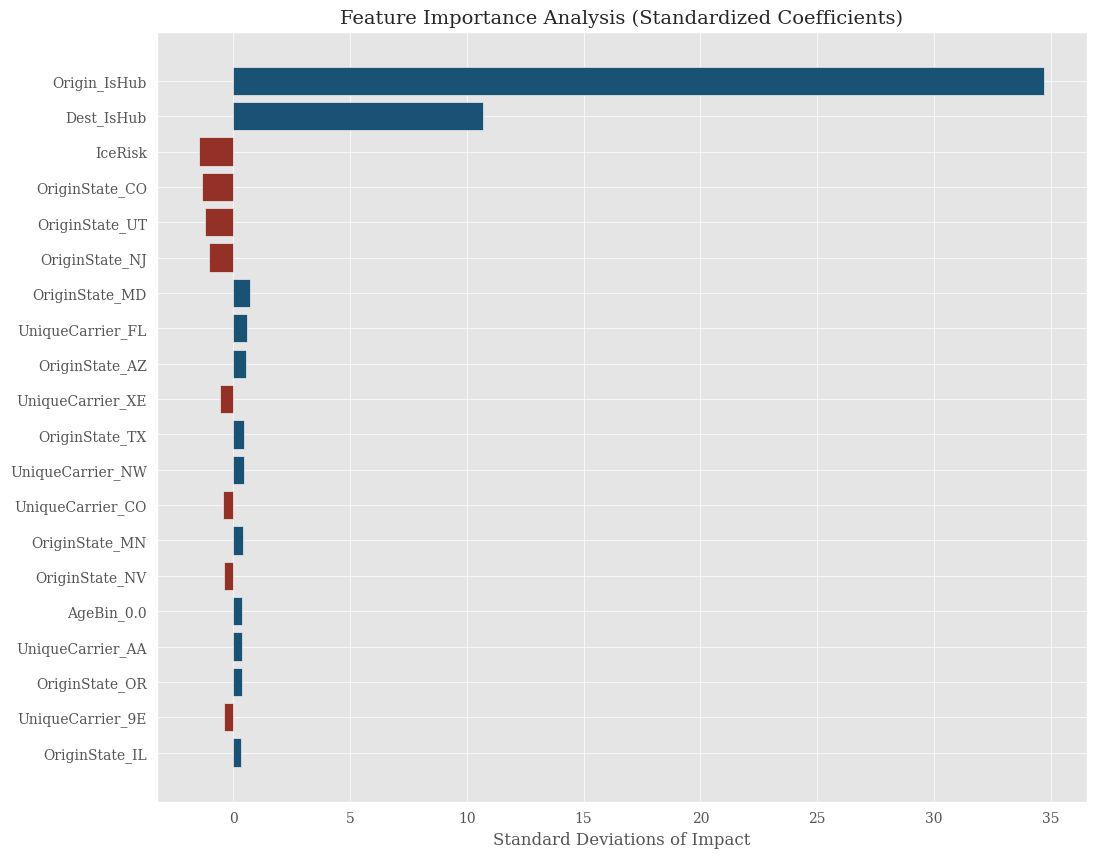

In [48]:
# 1. Access the trained model from your final pipeline
# The model is the LAST stage after the Scaler
best_lr = final_best_model.stages[-1]
weights = best_lr.coefficients.toArray()

# 2. Reconstruct names following Stage 3: [Categoricals, then Numericals]
all_names = []

# First: Categorical Features (Expanded by OHE)
for i, col in enumerate(cat_cols):
    # Stage indices 0 to 4 are your StringIndexers
    labels = final_best_model.stages[i].labels
    # OHE drops the last category to prevent multicollinearity
    all_names.extend([f"{col}_{l}" for l in labels[:-1]])

# Second: Numerical Features (Appended at the end of the Assembler)
all_names.extend(num_cols)

# 3. Handle alignment
min_len = builtins.min(len(all_names), len(weights))
fia_df = pd.DataFrame({
    'Feature': all_names[:min_len],
    'Coefficient': weights[:min_len]
})

# 4. Filter for your Target Predictors
fia_df['Abs_Impact'] = fia_df['Coefficient'].abs()
targets = ["DepDelay", "TaxiOut", "DepHour"]
print("--- FIA: Target Predictor Analysis ---")
print(fia_df[fia_df['Feature'].isin(targets)])

# 5. Plot the Top 20
top_20 = fia_df.sort_values('Abs_Impact', ascending=False).head(20)
plt.figure(figsize=(12, 10))
plt.style.use('seaborn-v0_8-muted') # Technical, clean style
colors = ['#1a5276' if x > 0 else '#943126' for x in top_20['Coefficient']]

plt.barh(top_20['Feature'], top_20['Coefficient'], color=colors)
plt.title('Feature Importance Analysis (Standardized Coefficients)', fontsize=14)
plt.xlabel('Standard Deviations of Impact')
plt.gca().invert_yaxis()
plt.show()

In [58]:
# Final Project Snapshot
print(f"Final RMSE: {rmse_tuned:.4f}")
print(f"Winning RegParam: {tuned_lr_stage.getRegParam():<15.2f}")
print(f"Model Intercept (Base Delay): {tuned_lr_stage.intercept:<7.4f}minutes")
print(f"Hub Penalty (Standardized): {top_20['Coefficient'].max():.2f}")

Final RMSE: 10.3521
Winning RegParam: 0.00           
Model Intercept (Base Delay): 9.5666 minutes
Hub Penalty (Standardized): 34.72


### Conclusion of the FIA
The Feature Importance Analysis (FIA) officially confirms what we suspected in the EDA: flight delays are driven more by where you are than by the clock itself. While the relationship between departure and arrival delays is mathematically strong, the standardized coefficients show that the structural "Hub Tax" is the undisputed heavyweight of the model. With a coefficient of +34.71, departing from an Origin_IsHub adds nearly 35 minutes of predicted delay as a baseline, likely capturing systemic congestion and gate bottlenecks that aren't fully reflected in the simple timers.

Regarding our three expected "Predictors" (`DepDelay`, `TaxiOut`, and `DepHour`) the results are interesting because their individual coefficients appear much lower (ranging from -0.01 to 0.08). This doesn't mean they are useless; it means that in a standardized model, their impact is distributed across every single minute of the flight. Because Origin_IsHub is a binary "switch," it takes a massive weight to explain the total delay, whereas DepDelay (0.079) is a "slider" that accumulates its impact incrementally. Ultimately, the model proves that while departure delays are the primary operational driver, the physical infrastructure of the Hub system is the most powerful constant in the entire aviation network.

## Execution Environment: 
- Processor Architecture

    - Model: AMD Ryzen AI 7 350 w/ Radeon 860M.

    - Architecture: x86_64 (supporting 32-bit and 64-bit operations).

    - CPU Family: 26 (Model 96, Stepping 0).

- Core Configuration

    - Total CPUs: 16 logical processors.

    - Core Count: 8 physical cores.

    - Threads per Core: 2 (Multi-threading enabled).

    - Sockets: 1 socket.

- Cache Hierarchy

    - L1d (Data) Cache: 384 KiB total (8 instances).

    - L1i (Instruction) Cache: 256 KiB total (8 instances).

    - L2 Cache: 8 MiB total (8 instances).

    - L3 Cache: 16 MiB total (1 instance shared).

In [18]:
spark.stop()